# Pacotes e Funções

In [25]:
from fast_ml import eda
from fast_ml.model_development import train_valid_test_split
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib.legend_handler import HandlerLine2D
from sklearn.model_selection import TimeSeriesSplit
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2OGradientBoostingEstimator

# Obtenção dos Dados

## Web-Scraping (Não sei se será necessário)

In [ ]:
FIPE_BR = url='https://www.investing.com/economic-calendar/brazilian-ipc-fipe-inflation-index-1562'


In [ ]:
pag = requests.get('https://www.investing.com/economic-calendar/brazilian-markit-manufacturing-pmi-1476')
PMI_BR = BeautifulSoup(pag.content,'html.parser')
rows = PMI_BR.select('table tbody tr')  

## Dummy Variables (Enquanto não temos os dados)

In [26]:
#Para testar de acordo com as variáveis do mercado é importante que os dados representem
#  uma série temporal, logo criamos os indexes antes.
series=pd.date_range(start='2009-01-01',end='2020-12-01',freq = 'D')

In [27]:
# Cria as variáveis independentes

dummy_independent1 = np.random.choice([-1,0,1],size=(len(series)))
dummy_independent2 = np.random.choice([-1,0,1],size=(len(series)))
dummy_independent3 = np.random.choice([-1,0,1],size=(len(series)))
dummy_independent4 = np.random.choice([-1,0,1],size=(len(series)))
dummy_independent5 = np.random.choice([-1,0,1],size=(len(series)))


# Junta as variáveis em um dataframe e define o index como a série temporal
dummy_df = pd.DataFrame({'x1':dummy_independent1,'x2':list(dummy_independent2),
'x3':list(dummy_independent3),'x4':list(dummy_independent4),'x5':list(dummy_independent5)},
columns=['x1','x2','x3','x4','x5'],index = series)

dummy_dependent = pd.DataFrame((np.random.choice([-1,0,1],size=len(series))),index=series)

In [28]:
# Cria as variáveis independentes

dummy_independent1 = np.random.choice([-1,0,1],size=(len(series)))
dummy_independent2 = np.random.choice([-1,0,1],size=(len(series)))
dummy_independent3 = np.random.choice([-1,0,1],size=(len(series)))
dummy_independent4 = np.random.choice([-1,0,1],size=(len(series)))
dummy_independent5 = np.random.choice([-1,0,1],size=(len(series)))


# Junta as variáveis em um dataframe e define o index como a série temporal
array0 =np.array([dummy_independent1,dummy_independent2,dummy_independent3,dummy_independent4,dummy_independent5])

In [29]:
array_tuple = (dummy_independent1,dummy_independent2,dummy_independent3,dummy_independent4,dummy_independent5)
array0 = pd.DataFrame((np.vstack(array_tuple).T),index=series)

In [30]:
teste = pd.merge(dummy_dependent, array0, left_index=True, right_index=True)
teste.rename(columns={'0_x':'Y','0_y':'X0','1':'X2'})

teste['data']=teste.index

# Pré Processamento dos Dados

## Divisão Treino-Validação-Teste (Variáveis Comuns, não séries temporais)

In [32]:
# Validação e Treino
x_train,x_valid,y_train,y_valid = train_test_split(dummy_df, dummy_dependent, train_size = 0.8,random_state=0)
#Treino e Teste
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=0)

## Para séries temporais

In [33]:
        
tscv = TimeSeriesSplit(n_splits=4)

### Dividimos o uso dos dados sequencialmente

In [34]:
x_train,y_train,x_valid,y_valid,x_test,y_test = train_valid_test_split(teste,target='0_x',method='sorted',sort_by_col= 'data',train_size=0.7,valid_size=0.2,test_size=0.1)

x_train = x_train.drop('data',axis=1)
x_valid = x_valid.drop('data',axis=1)
x_test = x_test.drop('data',axis=1)

### Com validation sample

### A tentativa abaixo falhou em separar de forma sequencial os dados.


for train_index, test_index in tscv.split(array0):
    # 80:20 training:validation inner loop split
    inner_split_point = int(0.8*len(train_index))
    
    valid_index = train_index[inner_split_point:]
    train_index = train_index[:inner_split_point]

    # Para observar adicione: print("TRAIN:", train_index, "VALID:", valid_index, "TEST:", test_index)
    
    x_train, x_valid, x_test = array0[train_index], array0[valid_index], array0[test_index]
    y_train, y_valid, y_test = dummy_dependent[train_index], dummy_dependent[valid_index], dummy_dependent[test_index]

## Teste (Random Forest Classifier)

### Teste de Overfitting por parametro de depth ( para observar outros parâmetros, criar um array com as opções e um for loop)

In [35]:
# Formula para criar um array 3D formado por outros arrays: z = np.array(np.meshgrid(param_range,number_trees)).T

In [36]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
param_grid = {'n_estimators':numero}

modelo = RandomForestClassifier(random_state=0)
sh= HalvingGridSearchCV(modelo,param_grid,cv=5,factor=2,resource='n_samples').fit(x_train,y_train)

ImportError: cannot import name 'enable_halving_search_cv' from 'sklearn.experimental' (C:\Users\Bruno Marcelino\anaconda3\lib\site-packages\sklearn\experimental\__init__.py)

In [80]:
train_errors = []
valid_errors = []
param_range = np.arange(1,50)
param2 = np.arange(1,50,5)

for n in param_range:
        for z in param2:
                random_forest = RandomForestClassifier(max_depth=z, n_estimators=n, random_state=1,criterion='gini')
                random_forest.fit(x_train, y_train)
    
                train_errors.append(np.sqrt(mean_squared_error(y_train, random_forest.predict(x_train))))
                valid_errors.append(np.sqrt(mean_squared_error(y_valid, random_forest.predict(x_valid))))


In [86]:
lista = []
for i in range(len(param_range)):
    for j in param2:
        lista.append(j)
        
lista

[1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 41,
 46,
 1,
 6,
 11,
 16,
 21,
 26,
 31,
 36,
 4

In [89]:
param_range = list(range(1,491))

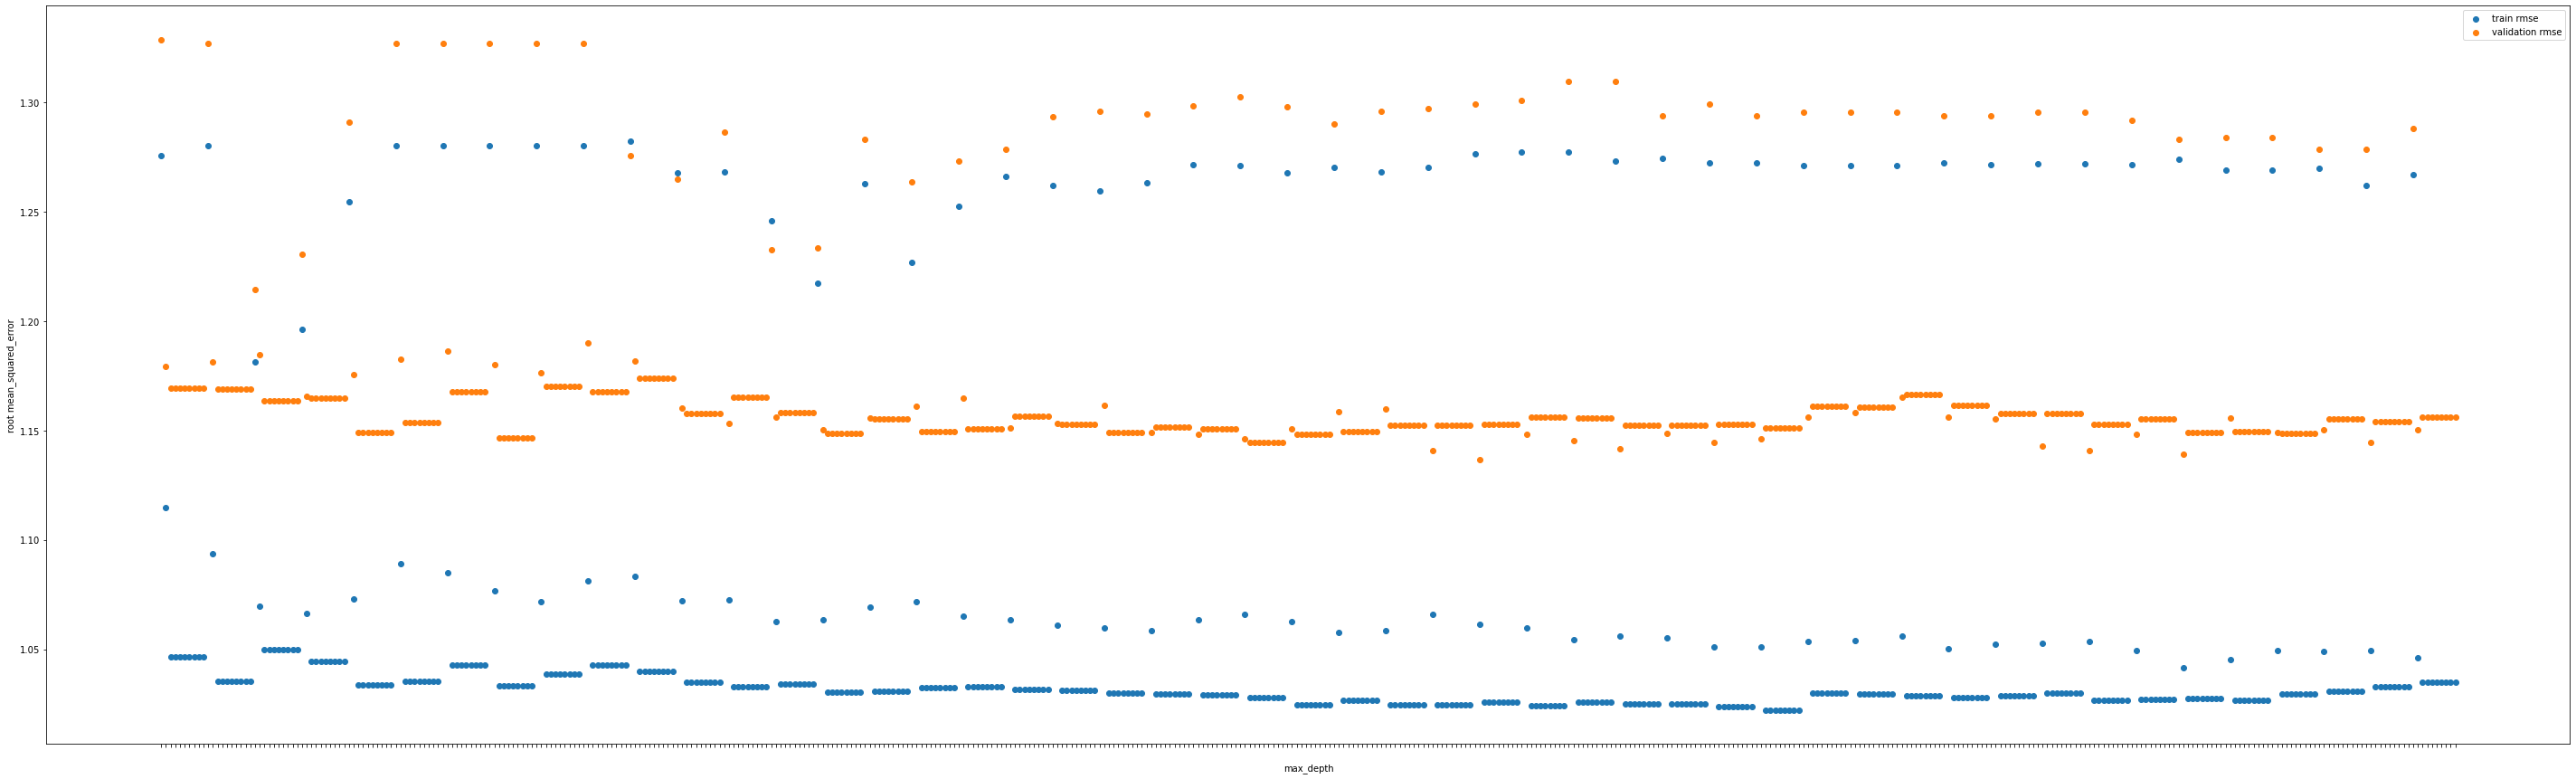

In [94]:
plt.figure(figsize = (50,15))
plt.xlabel('max_depth')
plt.ylabel('root mean_squared_error')
plt.scatter(param_range, train_errors, label="train rmse")
plt.scatter(param_range, valid_errors, label="validation rmse")
plt.xticks(param_range, color = "white")
plt.legend()
plt.show()

In [92]:
min(train_errors)

1.0222339546105128

In [ ]:
np.minimum(valid_errors,train_errors)

In [ ]:
param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
from sklearn.model_selection import GridSearchCV
CV_rfc = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv= 1)
CV_rfc.fit(x_train, y_train)
print(CV_rfc.best_params_)

### Teste do resultado

In [ ]:
random_forest = RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=1)
random_forest.fit(x_train, y_train)
y_pred= random_forest.predict(x_test)
root_mean_squared_error = np.sqrt(mean_squared_error(y_test, random_forest.predict(x_test)))
root_mean_squared_error

## Plots

#### Plot de significância das variáveis

In [ ]:
col = dummy_df.columns
y=random_forest.estimators_
fig, ax = plt.subplots()
width = 0.3
ind = np.arange(len(y))
ax.barh(ind,y,width,color= 'green')
ax.set_yticklabels(col,minor=False)
ax.set_yticks(ind+width/10)


plt.title('Significância das Variáveis')
plt.xlabel('Significância Relativa')
plt.ylabel('Variável')
plt.figure(figsize=(10,5))

#### Árvore de Decisão

In [ ]:
import os
from sklearn.tree import export_graphviz
import six

import pydot

export_graphviz(random_forest.estimators_[1], out_file='tree.dot', 
                feature_names = dummy_df.columns,
                class_names = dummy_df.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)
#Usar parâmetro max_depth para limitar a quantidade de árvores mostradas

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=1000'])

from IPython.display import Image
Image(filename = 'tree.png')

## Teste (Gradient Boosting)